## Port of CHIME model to simple Jupyter notebook

**IMPORTANT NOTE: This was based on a very EARLY VERSION of the CHIME model. Nevertheless,
the comments might still be useful to someone trying to understand the basic
logic of the model.**

**DO NOT USE ME FOR ACTUAL WORK**

Just pulling out the code bits from the CHIME streamlit app for trying to build and test new resource logic. I'm keeping in some of the streamlit app code in but just commenting it out.

https://github.com/pennsignals/chime

I've added tons of code comments and other descriptive text throughout the notebook to help others understand exactly how this works and how we might adapt it for our use.

The work below is based on the terrific work of the UPenn team and the CodeForPhilly project. Their project is under an MIT License. This notebook, which is derived from the CHIME project, is also licensed with an MIT License. The license and copyright info can be found at the bottom of the notebook.

In [1]:
from functools import reduce
from typing import Tuple, Dict, Any
import pandas as pd
#import streamlit as st
import numpy as np
#import altair as alt

from IPython.display import display, Markdown, Latex


In [2]:
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

## Input parameters

### Define region to model
The following input parameters define the region we are modeling in any given scenario.

In [4]:
# TODO: Just made these up. Need real counties and pops.
oakland = 1248141
macomb = 867502
wayne = 1778396
washtenaw = 326058
stclair = 158313
S_default = oakland + macomb + wayne + washtenaw + stclair

In [5]:
# TODO: Just left these in from Penn app - they are numbers for the entire *region* being
# modeled, where region is defined by whatever counties and populations we put in
# previous cell.
known_infections = 91 # update daily
known_cases = 4 # update daily

## SIR and resource model input parameters

In [7]:

# Currently Hospitalized COVID-19 Patients
current_hosp = known_cases

# Doubling time before social distancing (days)
doubling_time = 6

# Social distancing (% reduction in social contact)
relative_contact_rate = 0.0

# Hospitalization %(total infections)
hosp_rate = 0.05

# ICU %(total infections)
icu_rate = 0.02

# Ventilated %(total infections)
vent_rate = 0.01
# Hospital average Length of Stay (days)
hosp_los = 7
# ICU average Length of Stay (days)
icu_los = 9
# Vent average Length of Stay (days)
vent_los = 10

# Hospital Market Share (%)
BH_market_share = 0.15

# Regional Population
S = S_default

# Currently Known Regional Infections (only used to compute detection rate - does not change projections
initial_infections = known_infections

## Compute values needed for modeling
Based on input parameter values, we can compute a bunch of key intermediate values that are used to drive the simulation and the resource computations. This is where we do stuff that needs to be computed before main simulation can run.

Good overview of SIR model available at https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology.

In [6]:
# Seems like estimating initial number of total infections in the population *region*
# we are modeling (i.e. that we put population numbers in above) by inferring from the
# number we have in hospital and then inflating by both our market share and then
# the hospitalization rate of infecteds. So, total_infections is in our entire
# region.

total_infections = current_hosp / BH_market_share / hosp_rate

# Estimate prob[detection | infected]. Will be used to initialize size of I.
detection_prob = initial_infections / total_infections

# Compute initial values for S, I, and R (susceptible, infectious, recovered)
# Note that initial value for S was set up above based on input params
# I is initialized by reflecting the fact that there are a bunch of undetected
# cases out there and R is initially set to 0.
S, I, R = S, initial_infections / detection_prob, 0

# Since this model lets user input the doubling time (time for I -> 2I), we can back into the
# implied intrinsic growth rate of the pandemic. We'll use this below to get to 
# key model terms like "basic reproduction number"
intrinsic_growth_rate = 2 ** (1 / doubling_time) - 1

recovery_days = 14.0 # Hmm, this is hard coded. Probably should get moved up into input params.
# mean recovery rate, gamma, (in 1/days).
gamma = 1 / recovery_days

# Contact rate, beta
beta = (
    intrinsic_growth_rate + gamma
) / S * (1-relative_contact_rate) # {rate based on doubling time} / {initial S}

# Now can compute the "basic reproduction number". It's kind of like the
# rho term in queueing models. When > 1, epidemic grows.
r_t = beta / gamma * S # r_t is r_0 after distancing
r_naught = r_t / (1-relative_contact_rate)
doubling_time_t = 1/np.log2(beta*S - gamma +1) # doubling time after distancing

## Credits and illustrating rendering
I wanted to keep the UPenn credits and info as well as show how easy it is to render and display Markdown in a Jupyter notebook.

In [19]:
display(Markdown(
        """*This tool was developed by the [Predictive Healthcare team](http://predictivehealthcare.pennmedicine.org/) at
    Penn Medicine. For questions and comments please see our
    [contact page](http://predictivehealthcare.pennmedicine.org/contact/). Code can be found on [Github](https://github.com/pennsignals/chime).
    Join our [Slack channel](https://codeforphilly.org/chat?channel=covid19-chime-penn) if you would like to get involved!*"""))


*This tool was developed by the [Predictive Healthcare team](http://predictivehealthcare.pennmedicine.org/) at
    Penn Medicine. For questions and comments please see our
    [contact page](http://predictivehealthcare.pennmedicine.org/contact/). Code can be found on [Github](https://github.com/pennsignals/chime).
    Join our [Slack channel](https://codeforphilly.org/chat?channel=covid19-chime-penn) if you would like to get involved!*

In [14]:
display(Markdown("""The estimated number of currently infected individuals is **{total_infections:.0f}**. The **{initial_infections}**
    confirmed cases in the region imply a **{detection_prob:.0%}** rate of detection. This is based on current inputs for
    Hospitalizations (**{current_hosp}**), Hospitalization rate (**{hosp_rate:.0%}**), Region size (**{S}**),
    and Hospital market share (**{BH_market_share:.0%}**).

An initial doubling time of **{doubling_time}** days and a recovery time of **{recovery_days}** days imply an $R_0$ of
**{r_naught:.2f}**.

**Mitigation**: A **{relative_contact_rate:.0%}** reduction in social contact after the onset of the outbreak reduces the doubling time to **{doubling_time_t:.1f}** days, implying an effective $R_t$ of **${r_t:.2f}$**.
""".format(
        total_infections=total_infections,
        initial_infections=initial_infections,
        detection_prob=detection_prob,
        current_hosp=current_hosp,
        hosp_rate=hosp_rate,
        S=S,
        BH_market_share=BH_market_share,
        recovery_days=recovery_days,
        r_naught=r_naught,
        doubling_time=doubling_time,
        relative_contact_rate=relative_contact_rate,
        r_t=r_t,
        doubling_time_t=doubling_time_t
    )))

The estimated number of currently infected individuals is **533**. The **91**
    confirmed cases in the region imply a **17%** rate of detection. This is based on current inputs for
    Hospitalizations (**4**), Hospitalization rate (**5%**), Region size (**500000**),
    and Hospital market share (**15%**).

An initial doubling time of **6** days and a recovery time of **14.0** days imply an $R_0$ of
**2.71**.

**Mitigation**: A **0%** reduction in social contact after the onset of the outbreak reduces the doubling time to **6.0** days, implying an effective $R_t$ of **$2.71$**.


## The SIR Model
For now just pasting in the model description code from the web app. **IMPORTANT: See web app at https://penn-chime.phl.io/ for readable version - it's got very helpful description of how this model works. You need to CHECK THE BOX labelled "Show more info about this tool".**

In [ ]:
# def show_more_info_about_this_tool():
#     """a lot of streamlit writing to screen."""

#     st.subheader(
#         "[Discrete-time SIR modeling](https://mathworld.wolfram.com/SIRModel.html) of infections/recovery"
#     )
#     st.markdown(
#         """The model consists of individuals who are either _Susceptible_ ($S$), _Infected_ ($I$), or _Recovered_ ($R$).

# The epidemic proceeds via a growth and decline process. This is the core model of infectious disease spread and has been in use in epidemiology for many years."""
#     )
#     st.markdown("""The dynamics are given by the following 3 equations.""")

#     st.latex("S_{t+1} = (-\\beta S_t I_t) + S_t")
#     st.latex("I_{t+1} = (\\beta S_t I_t - \\gamma I_t) + I_t")
#     st.latex("R_{t+1} = (\\gamma I_t) + R_t")

#     st.markdown(
#         """To project the expected impact to Penn Medicine, we estimate the terms of the model.

# To do this, we use a combination of estimates from other locations, informed estimates based on logical reasoning, and best guesses from the American Hospital Association.


# ### Parameters

# The model's parameters, $\\beta$ and $\\gamma$, determine the virulence of the epidemic.

# $$\\beta$$ can be interpreted as the _effective contact rate_:
# """)
#     st.latex("\\beta = \\tau \\times c")

#     st.markdown(
# """which is the transmissibility ($\\tau$) multiplied by the average number of people exposed ($$c$$).  The transmissibility is the basic virulence of the pathogen.  The number of people exposed $c$ is the parameter that can be changed through social distancing.


# $\\gamma$ is the inverse of the mean recovery time, in days.  I.e.: if $\\gamma = 1/{recovery_days}$, then the average infection will clear in {recovery_days} days.

# An important descriptive parameter is the _basic reproduction number_, or $R_0$.  This represents the average number of people who will be infected by any given infected person.  When $R_0$ is greater than 1, it means that a disease will grow.  Higher $R_0$'s imply more rapid growth.  It is defined as """.format(recovery_days=int(recovery_days)    , c='c'))
#     st.latex("R_0 = \\beta /\\gamma")

#     st.markdown("""

# $R_0$ gets bigger when

# - there are more contacts between people
# - when the pathogen is more virulent
# - when people have the pathogen for longer periods of time

# A doubling time of {doubling_time} days and a recovery time of {recovery_days} days imply an $R_0$ of {r_naught:.2f}.

# #### Effect of social distancing

# After the beginning of the outbreak, actions to reduce social contact will lower the parameter $c$.  If this happens at
# time $t$, then the number of people infected by any given infected person is $R_t$, which will be lower than $R_0$.

# A {relative_contact_rate:.0%} reduction in social contact would increase the time it takes for the outbreak to double,
# to {doubling_time_t:.2f} days from {doubling_time:.2f} days, with a $R_t$ of {r_t:.2f}.

# #### Using the model

# We need to express the two parameters $\\beta$ and $\\gamma$ in terms of quantities we can estimate.

# - $\\gamma$:  the CDC is recommending 14 days of self-quarantine, we'll use $\\gamma = 1/{recovery_days}$.
# - To estimate $$\\beta$$ directly, we'd need to know transmissibility and social contact rates.  since we don't know these things, we can extract it from known _doubling times_.  The AHA says to expect a doubling time $T_d$ of 7-10 days. That means an early-phase rate of growth can be computed by using the doubling time formula:
# """.format(doubling_time=doubling_time,
#            recovery_days=recovery_days,
#            r_naught=r_naught,
#            relative_contact_rate=relative_contact_rate,
#            doubling_time_t=doubling_time_t,
#            r_t=r_t)
#     )
#     st.latex("g = 2^{1/T_d} - 1")

#     st.markdown(
#         """
# - Since the rate of new infections in the SIR model is $g = \\beta S - \\gamma$, and we've already computed $\\gamma$, $\\beta$ becomes a function of the initial population size of susceptible individuals.
# $$\\beta = (g + \\gamma)$$.


# ### Initial Conditions

# - The total size of the susceptible population will be the entire catchment area for Penn Medicine entities (HUP, PAH, PMC, CCH)
#   - Delaware = {delaware}
#   - Chester = {chester}
#   - Montgomery = {montgomery}
#   - Bucks = {bucks}
#   - Philly = {philly}""".format(
#             delaware=delaware,
#             chester=chester,
#             montgomery=montgomery,
#             bucks=bucks,
#             philly=philly,
#         )
#     )
#     return None

# if st.checkbox("Show more info about this tool"):
#     show_more_info_about_this_tool()

### Single time step of model
The following function updates S, I and R for a single time step. It will get called repeatedly from main simulation loop.

In [20]:
# The SIR model, one time step
def sir(y, beta, gamma, N):
    S, I, R = y
    Sn = (-beta * S * I) + S
    In = (beta * S * I - gamma * I) + I
    Rn = gamma * I + R
    if Sn < 0:
        Sn = 0
    if In < 0:
        In = 0
    if Rn < 0:
        Rn = 0

    scale = N / (Sn + In + Rn)
    return Sn * scale, In * scale, Rn * scale

### Main simulation function
Initialize with our current values of S, I, and R based on user input parameters and then loop for a specified number of days. 

Looks like there's a "hook" to be able to model decay in $\beta$, the effective contact rate, but the default is to assume no decay. This allows being able to model things like changes in basic virulence of the virus.

This `sim_sir()` function will get called from the next bit of main code in the next cell.

In [21]:
# Run the SIR model forward in time
def sim_sir(S, I, R, beta, gamma, n_days, beta_decay=None):
    N = S + I + R
    s, i, r = [S], [I], [R]
    for day in range(n_days):
        y = S, I, R
        S, I, R = sir(y, beta, gamma, N)
        if beta_decay:
            beta = beta * (1 - beta_decay)
        s.append(S)
        i.append(I)
        r.append(R)

    s, i, r = np.array(s), np.array(i), np.array(r)
    return s, i, r

Now we are ready to run the simulation. In the code below, the line that actually calls the sim function is:

    s, i, r = sim_sir(S, I, R, beta, gamma, n_days, beta_decay=beta_decay)
    
So, the result is a tuple of numpy arrays representing the size of S, I, and R at each time step. We'll then be able to use these to drive resource related calculations that depend on them.


In [23]:
# How many do days you want to run this for?
n_days = 60

# Assume no beta decay for now.
beta_decay = 0.0

# Call the main simulation function. 
s, i, r = sim_sir(S, I, R, beta, gamma, n_days, beta_decay=beta_decay)

# Compute arrays of resource use at each time step
# Note that the three resources included in the base model are just using
# "multipliers" to compute hospital specific guesstimates of resource needs.
# A similar kind of thing might be appropriate for many resources such
# as needs for numbers of certain kinds of staff.
hosp = i * hosp_rate * BH_market_share
icu = i * icu_rate * BH_market_share
vent = i * vent_rate * BH_market_share

# Now read to create master DataFrame to drive plots

# Need array of the days
days = np.array(range(0, n_days + 1))

# Combine arrays for days and all resource related arrays.
# Obviously, as new resource computations are added above,
# need to add those arrays to data_list
data_list = [days, hosp, icu, vent]

# Create a dictionary from data_list to use to easily create pandas DataFrame.
data_dict = dict(zip(["day", "hosp", "icu", "vent"], data_list))

# Create the main DataFrame containing resource projections.
projection = pd.DataFrame.from_dict(data_dict)

The variable `projection` contains the pandas dataframe that drives the graphs. As you add more resources beyond just vents and ICUs, then you just make sure you add the arrays to the `data_list` in the code chunk above.

In [24]:
projection

,day,hosp,icu,vent
0,0,4.000000,1.600000,0.800000
1,1,4.489848,1.795939,0.897970
2,2,5.039504,2.015802,1.007901
3,3,5.656223,2.262489,1.131245
4,4,6.348129,2.539252,1.269626
...,...,...,...,...
56,56,919.761010,367.904404,183.952202
57,57,945.778913,378.311565,189.155783
58,58,968.047868,387.219147,193.609574
59,59,986.345249,394.538099,197.269050


### New Admissions
Projected number of **daily** COVID-19 admissions

In [25]:
# New cases (computing lag 1 difference)
projection_admits = projection.iloc[:-1, :] - projection.shift(1)
projection_admits[projection_admits < 0] = 0

plot_projection_days = n_days - 10
projection_admits["day"] = range(projection_admits.shape[0])

In [26]:
projection_admits

,day,hosp,icu,vent
0,0,NaN,NaN,NaN
1,1,0.489848,0.195939,0.097970
2,2,0.549656,0.219862,0.109931
3,3,0.616719,0.246688,0.123344
4,4,0.691906,0.276762,0.138381
...,...,...,...,...
56,56,29.468063,11.787225,5.893613
57,57,26.017903,10.407161,5.203581
58,58,22.268955,8.907582,4.453791
59,59,18.297381,7.318952,3.659476


Obviously, you can drive graphs from the `projection_admits` dataframe.

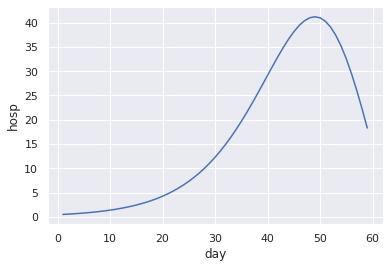

In [35]:
sns.lineplot(x="day", y="hosp", data=projection_admits);

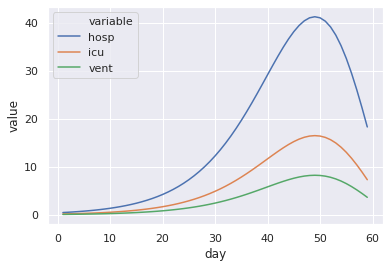

In [40]:
sns.lineplot(x='day', y='value', hue='variable', 
             data=pd.melt(projection_admits, ['day']));

### Census
Census of the COVID-19 related resources we are tracking

In [29]:
def _census_table(projection_admits, hosp_los, icu_los, vent_los) -> pd.DataFrame:
    """ALOS for each category of COVID-19 case (total guesses)"""

    los_dict = {
        "hosp": hosp_los,
        "icu": icu_los,
        "vent": vent_los,
    }

    census_dict = dict()
    for k, los in los_dict.items():
        census = (
            projection_admits.cumsum().iloc[:-los, :]
            - projection_admits.cumsum().shift(los).fillna(0)
        ).apply(np.ceil)
        census_dict[k] = census[k]


    census_df = pd.DataFrame(census_dict)
    census_df["day"] = census_df.index
    census_df = census_df[["day", "hosp", "icu", "vent"]]

    census_table = census_df[np.mod(census_df.index, 7) == 0].copy()
    census_table.index = range(census_table.shape[0])
    census_table.loc[0, :] = 0
    census_table = census_table.dropna().astype(int)

    return census_table

census_table = _census_table(projection_admits, hosp_los, icu_los, vent_los)

In [28]:
census_table

,day,hosp,icu,vent
0,0,0,0,0
1,7,5,2,1
2,14,12,6,3
3,21,25,12,7
4,28,53,25,14
5,35,106,50,27
6,42,191,92,49
7,49,272,135,73


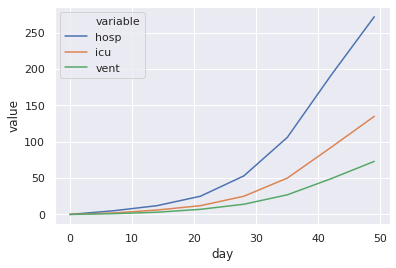

In [39]:
sns.lineplot(x='day', y='value', hue='variable', 
             data=pd.melt(census_table, ['day']));

This notebook was derived from the CHIME project (https://github.com/pennsignals/chime).

In [ ]:
MIT License

Copyright (c) 2020 Mark Isken
Copyright (c) 2020 The Trustees of the University of Pennsylvania

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.